# Prediction of Arrival Time in an E-Commerce
### Author: Data Squad
### Description: Shipment arrival prediction using machine learning algorithm
### Dataset: https://www.kaggle.com/prachi13/customer-analytics 
### Outline:
1. Data Extraction
2. Exploratory Data Analysis
3. Data Preparation
4. Model Evaluation

### Objective:
Perusahaan e-commerce yang menjual produk elektronik ingin memprediksi lama pengiriman atau waktu tiba paket berdasarkan data customer yang dimiliki dan menyelidiki kendala yang menyebabkan adanya keterlambatan suatu pengiriman. Hasil dari prediksi waktu tiba tersebut kemudian digunakan untuk rekomendasi bisnis selanjutnya, bergantung dari faktor-faktor penyebab keterlambatan.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 1. Data Extraction

In [149]:
data = pd.read_csv("data/Train.csv")

In [3]:
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


#### a. Data Exploration

The data contains the following information: ID: ID Number of Customers. Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E. Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road. Customer care calls: The number of calls made from enquiry for enquiry of the shipment. Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best). Cost of the product: Cost of the Product in US Dollars. Prior purchases: The Number of Prior Purchase. Product importance: The company has categorized the product in the various parameter such as low, medium, high. Gender: Male and Female. Discount offered: Discount offered on that specific product. Weight in gms: It is the weight in grams. Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [5]:
m = data.shape[0]
n = data.shape[1]

print("Number of rows: " + str(m))
print("Number of columns: " + str(n))

Number of rows: 10999
Number of columns: 12


#### b. Data Cleansing

In [6]:
# check missing values
data.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [7]:
# check duplicates
print("Number of duplicated data:", data.duplicated().sum())
print("Number of duplicated ID:", data["ID"].duplicated().sum())

Number of duplicated data: 0
Number of duplicated ID: 0


#### c. Features and Label

In [8]:
# drop id column 
data.drop(["ID"], axis = 1, inplace=True)

In [9]:
data_div = data.copy()

# converting
data_div['Reached.on.Time_Y.N'] = data_div['Reached.on.Time_Y.N'].astype('category')
data_div['Reached.on.Time_Y.N'].replace(1,'Not_On_Time', inplace=True)
data_div['Reached.on.Time_Y.N'].replace(0,'On_Time', inplace=True)

# separate features and target
label=data_div['Reached.on.Time_Y.N']
numericals = data_div.select_dtypes(include=['number'])
categoricals = data_div.drop(['Reached.on.Time_Y.N'], axis=1).select_dtypes(exclude=['number'])

print("\nlabel column:", label.name)
print("__________________________\n")
print("numerical columns:\n", numericals.columns)
print("__________________________\n")
print("categorical columns:\n", categoricals.columns)


label column: Reached.on.Time_Y.N
__________________________

numerical columns:
 Index(['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
       'Prior_purchases', 'Discount_offered', 'Weight_in_gms'],
      dtype='object')
__________________________

categorical columns:
 Index(['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'], dtype='object')


<font color="darkblue">
    <b><i>All features, except "ID", will be used to see the correlation and insights so there are not too many assumptions</i></b>
</font>

## 2. Exploratory Data Analysis

### 2.1 Descriptive Statistics

In [10]:
numericals.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000


In [11]:
categoricals.describe()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,10999,10999,10999,10999
unique,5,3,3,2
top,F,Ship,low,F
freq,3666,7462,5297,5545


<font color="darkblue">
    <b><i>There is a  significant difference between mean and median of 'Discount_offered' and 'Weight_in_gms' indicating skewed distribution</i></b>
</font>

### 2.2 Univariate Analysis

#### a. Countplot

In [12]:
label.value_counts()

Not_On_Time    6563
On_Time        4436
Name: Reached.on.Time_Y.N, dtype: int64

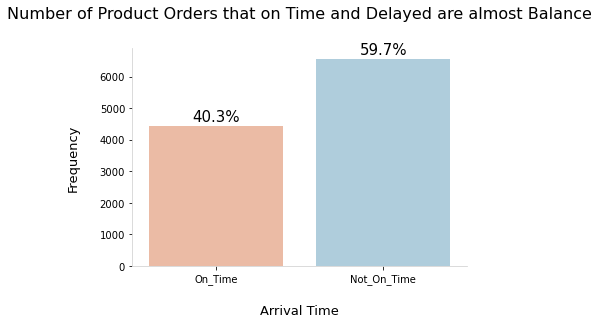

In [13]:
# plot
ax = sns.countplot(label, palette='RdBu')

total = float(len(label))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 150
    ax.annotate(percentage, (x, y), ha='center', fontsize=15)
    
# settings
plt.xlabel('Arrival Time', fontsize = 13, labelpad = 20)
plt.ylabel('Frequency', fontsize = 13, labelpad = 20)
plt.title('Number of Product Orders that on Time and Delayed are almost Balance', fontsize = 16, pad = 30)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')

<font color="darkblue">
    <b><i>The graph above shows that arrival time categories that are 'On Time' and 'Not On Time' have an almost balanced order frequency</i></b>
</font>

#### b. Boxplots

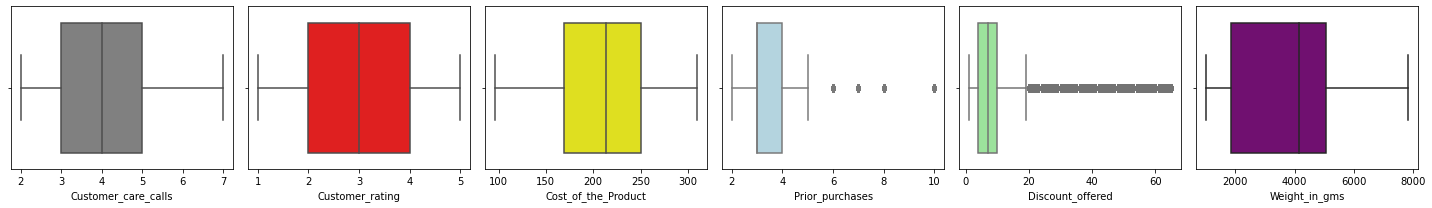

In [14]:
plt.figure(figsize=(20,3))
for i,colour in zip(range(0, len(numericals.columns)),['grey','red','yellow','lightblue','lightgreen','purple']):
    plt.subplot(1,len(numericals.columns),i+1)
    sns.boxplot(numericals[numericals.columns[i]], color=colour)
    plt.tight_layout()

<font color="darkblue">
    <ul><b><i>
        <li>The boxplot graphs above show that 'Prior_purchase' and 'Discount_offered' have a distribution affected by outliers shown on the graph. The outliers are piled up at the right end</li>
         <li>Weight_in_gms has an asymmetric distribution shown by median line that is not in the middle of interquartile range. However, there are no outliers on the graph. It may be affected by the number of modes that is more than 1 and imbalanced. The number of modes indicates there are different groups of Weight</li>
         <li>'Customer_care_calls','Customer_rating','Cost_of_the_Product' tend to have a normal distribution shown by median line in the midle of IQR</li>
    </i></b></ul>
</font>

#### c. Distplots

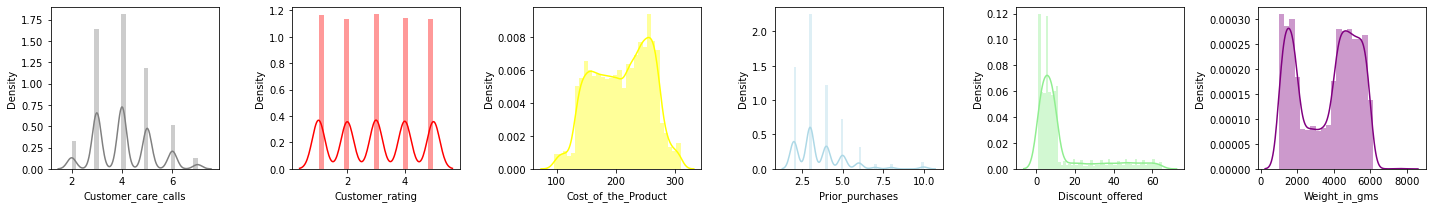

In [15]:
plt.figure(figsize=(20,3))
for i,colour in zip(range(0, len(numericals.columns)),['grey','red','yellow','lightblue','lightgreen','purple']):
    plt.subplot(1,len(numericals.columns),i+1)
    sns.distplot(numericals[numericals.columns[i]], color=colour)
    plt.tight_layout()

<font color="darkblue">
    <ul><b><i>
        <li>The distribution plots above show that 'Prior_purchase' and 'Discount_offered' have a skewed right (positively skewed) distribution where the data are piled up at the left end. There is a very small portion of the data collected on right side (outliers). It causes the mean > median</li>
         <li>Weight_in_gms has a bimodal distribution. It is affected by 2 imbalanced modes/peaks. It also indicates there are 2 different types of Weight</li>
         <li>'Customer_care_calls','Customer_rating','Cost_of_the_Product' tend to have a symmetric or normal distribution shown by nearly identical if folded in half at the center point of the distribution</li>
         <li>'Customer_care_calls' and 'Customer_rating' tend to have a multimodal distribution shown by multiple modes/peaks indicating there are different groups for each that feature</li>
          <li>'Customer_rating' has a uniform distribution, the probabilities are exactly the same at each point, so the distribution is basically a straight line</li>
    </i></b></ul>
</font>

### 2.3 Bivariate Analysis

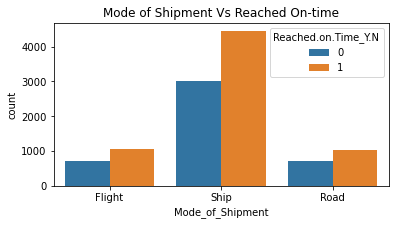

In [16]:
plt.figure(figsize=(6,3))
sns.countplot(data = data, x='Mode_of_Shipment', hue='Reached.on.Time_Y.N')
plt.title('Mode of Shipment Vs Reached On-time')
plt.show()

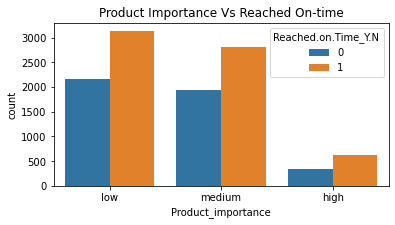

In [17]:
plt.figure(figsize=(6,3))
sns.countplot(data = data, x='Product_importance', hue='Reached.on.Time_Y.N')
plt.title('Product Importance Vs Reached On-time')
plt.show()

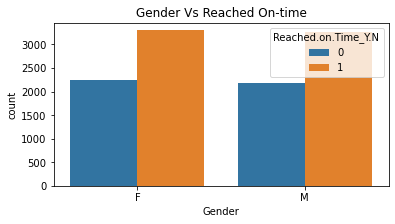

In [18]:
plt.figure(figsize=(6,3))
sns.countplot(data = data, x='Gender', hue='Reached.on.Time_Y.N')
plt.title('Gender Vs Reached On-time')
plt.show()

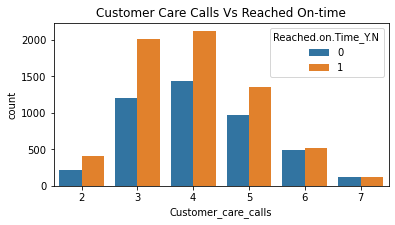

In [19]:
plt.figure(figsize=(6,3))
sns.countplot(data = data, x='Customer_care_calls', hue='Reached.on.Time_Y.N')
plt.title('Customer Care Calls Vs Reached On-time')
plt.show()

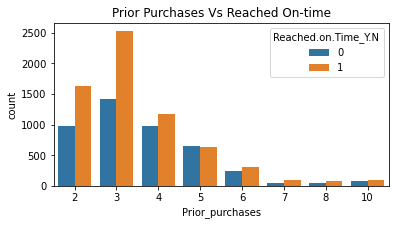

In [20]:
plt.figure(figsize=(6,3))
sns.countplot(data = data, x='Prior_purchases', hue='Reached.on.Time_Y.N')
plt.title('Prior Purchases Vs Reached On-time')
plt.show()

<font color="darkblue">
    <ul><b><i>
        <li>Ship is the most used mode of shipment and it is also the product most likely to be delivered late</li>
        <li>Despite the product importance is low, medium, or high, product most likely to be delivered late</li>
        <li>There is no difference between gender with Reached On-time</li>
        <li>The more customer care calls, the more product delivered late</li>
        <li>Even though the customer already made a prior purchase, the product still delivered late</li>
    </i></b></ul>
</font>

### 2.4 Multivariate Analysis

#### a. Pair Grid

In [21]:
import warnings
warnings.filterwarnings("ignore")

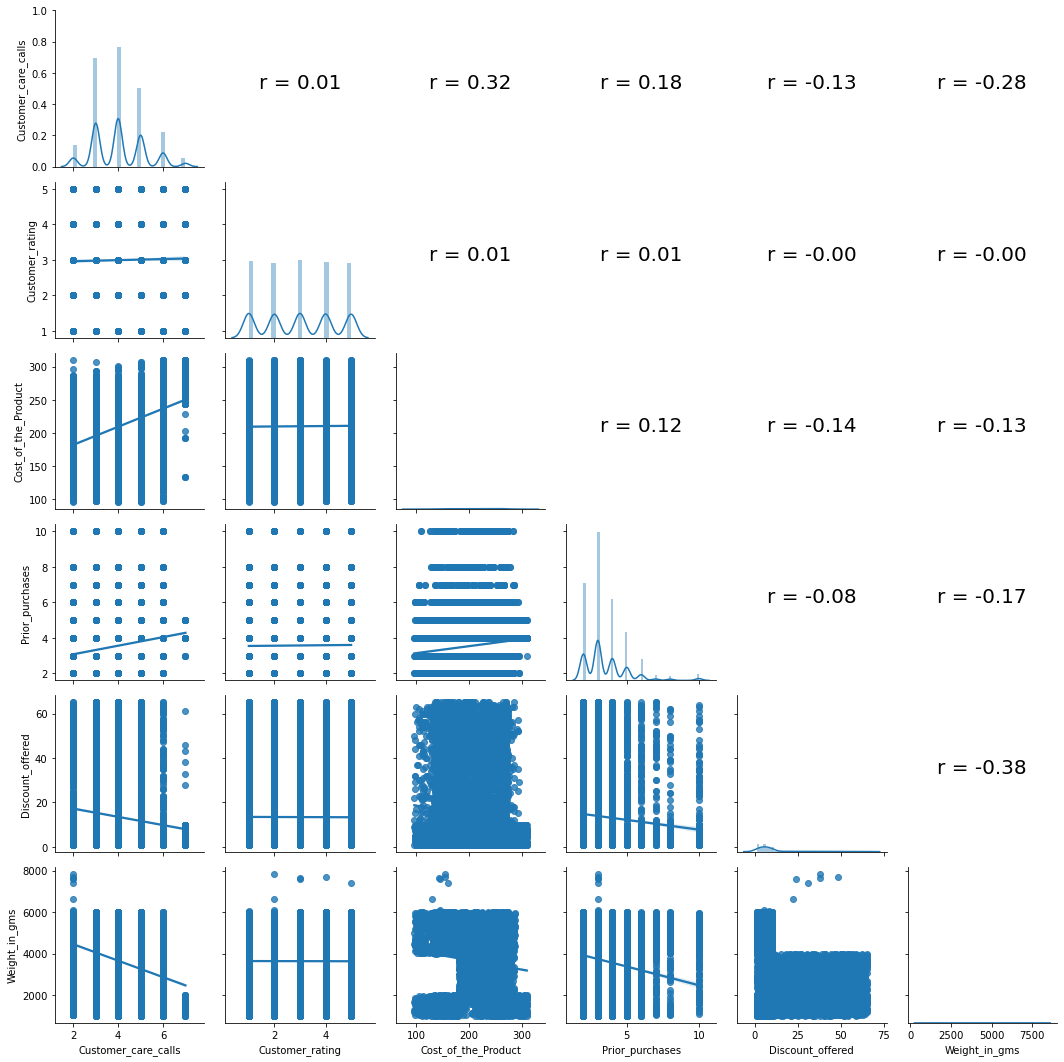

In [22]:
from scipy.stats import pearsonr

def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center', size=20)
    ax.set_axis_off()

g = sns.PairGrid(data=numericals)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef);

<font color="darkblue">
    <ul><b><i>
        <li>There are clear clusters shown on graph, that are 'Customer_care_calls', 'Customer_rating', and 'Prior_purchase'</li>
    </i></b></ul>
</font>

#### b. Pair plot + Hue

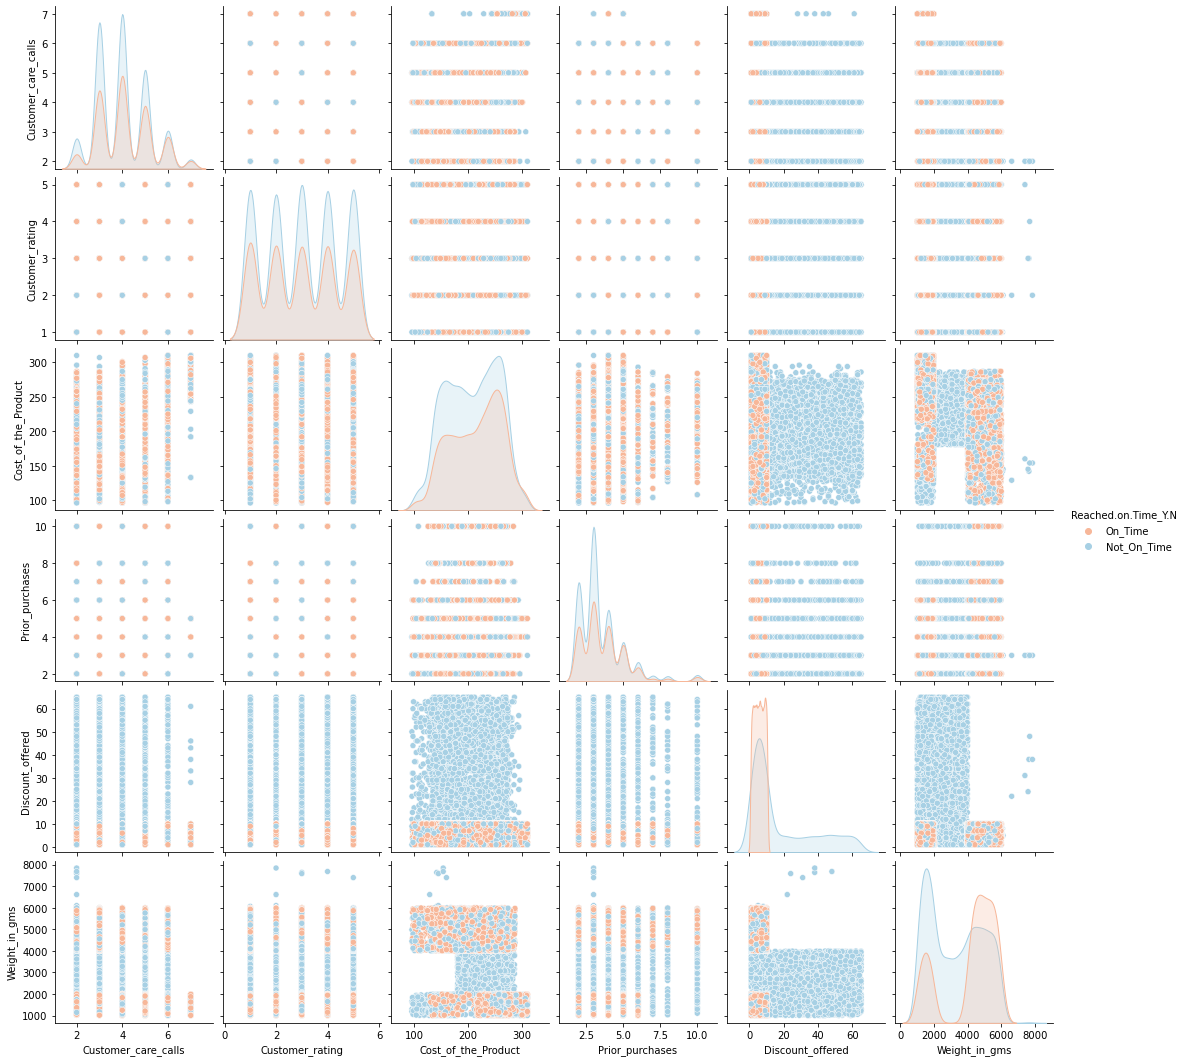

In [23]:
sns.pairplot(data=data_div, hue = "Reached.on.Time_Y.N", palette = "RdBu");

<font color="darkblue">
    <ul><b><i>
        <li>Product orders that on time tend to have the lowest 'Discount offered' and tend to have a highest and lowest 'Weight_in_gms'</li>
        <li>The on time and not on time categories on feature correlations between 'Discount_offered' and  the other features, as well as feature correlation between 'Weight_in_gms' and  the other features, tend to have well separated indicating a good combination of features</li>
    </i></b></ul>
</font>

#### c. Correlation Heatmap

In [24]:
# compute corr
data.corr(method = "pearson")

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
Customer_care_calls,1.000000,0.012209,0.323182,0.180771,-0.130750,-0.276615,-0.067126
Customer_rating,0.012209,1.000000,0.009270,0.013179,-0.003124,-0.001897,0.013119
Cost_of_the_Product,0.323182,0.009270,1.000000,0.123676,-0.138312,-0.132604,-0.073587
Prior_purchases,0.180771,0.013179,0.123676,1.000000,-0.082769,-0.168213,-0.055515
Discount_offered,-0.130750,-0.003124,-0.138312,-0.082769,1.000000,-0.376067,0.397108
Weight_in_gms,-0.276615,-0.001897,-0.132604,-0.168213,-0.376067,1.000000,-0.268793
Reached.on.Time_Y.N,-0.067126,0.013119,-0.073587,-0.055515,0.397108,-0.268793,1.000000


In [25]:
c = data.corr(method = "pearson")
c_sorted = c.sort_values( by=['Reached.on.Time_Y.N'], ascending = False )
c_sorted["Reached.on.Time_Y.N"]

Reached.on.Time_Y.N    1.000000
Discount_offered       0.397108
Customer_rating        0.013119
Prior_purchases       -0.055515
Customer_care_calls   -0.067126
Cost_of_the_Product   -0.073587
Weight_in_gms         -0.268793
Name: Reached.on.Time_Y.N, dtype: float64

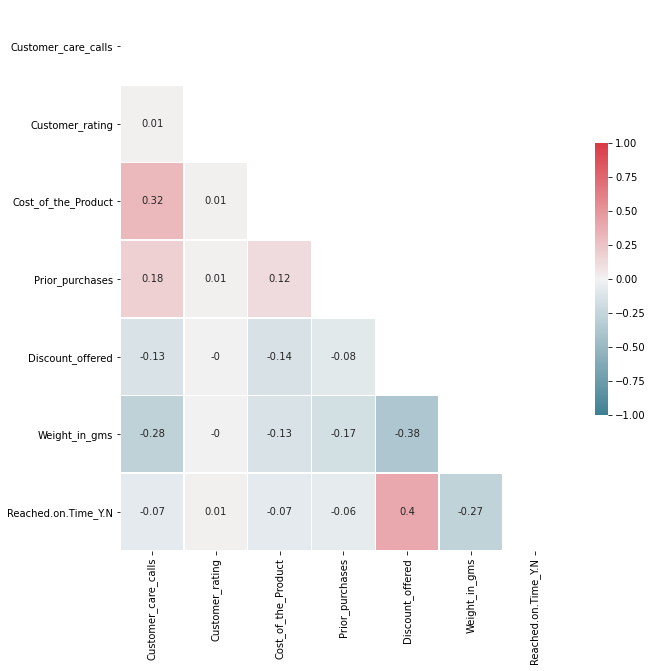

In [26]:
# compute correlation 
corr = data.corr(method = "pearson").round(2)

# mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# set figure size
f, ax = plt.subplots(figsize = (10,10))

# set colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, 
           vmin = -1, vmax = 1, center = 0,
           linewidths = .5, cbar_kws = {"shrink": .5}, annot = True);

<font color="darkblue">
    <ul><b><i>
        <li>There are no redundant features, no strong correlated features</li>
        <li>'Customer_care_calls' are positively correlated with 'Cost_of_the_Product' (r=0.32)</li>
        <li>There are negative correlation between 'Customer_care_calls' and 'Weight_in_gms' (r=-0.28), 'Discount_offered' and 'Weight_in_gms' (r=-0.38)</li>
    </i></b></ul>
</font>

## 3. Data Preprocessing

### Feature Selection

In [399]:
features = ["Discount_offered", "Customer_rating", "Prior_purchases", "Customer_care_calls", \
            "Cost_of_the_Product", "Weight_in_gms", "Warehouse_block", "Mode_of_Shipment", \
           "Product_importance", "Gender"]

In [400]:
data_features = data[features]
data_features['Reached.on.Time_Y.N'] = data['Reached.on.Time_Y.N']
data_features.head(2)

,Discount_offered,Customer_rating,Prior_purchases,Customer_care_calls,Cost_of_the_Product,Weight_in_gms,Warehouse_block,Mode_of_Shipment,Product_importance,Gender,Reached.on.Time_Y.N
0,44,2,3,4,177,1233,D,Flight,low,F,1
1,59,5,2,4,216,3088,F,Flight,low,M,1


In [213]:

data_features.head(2)

,Discount_offered,Customer_rating,Prior_purchases,Customer_care_calls,Cost_of_the_Product,Weight_in_gms,Warehouse_block,Mode_of_Shipment,Product_importance,Gender,Reached.on.Time_Y.N
0,44,2,3,4,177,1233,D,Flight,low,F,1
1,59,5,2,4,216,3088,F,Flight,low,M,1


### Normalization/Standardization

In [401]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler


std_columns = ['Customer_care_calls','Customer_rating','Cost_of_the_Product']
data_clean = data_features.copy()
for i in std_columns:
    data_clean[i] = StandardScaler().fit_transform(data_clean[i].values.reshape(len(data_clean),1))


norm_columns = ['Prior_purchases','Discount_offered','Weight_in_gms']
for i in norm_columns:
    data_clean[i] = MinMaxScaler().fit_transform(data_clean[i].values.reshape(len(data_clean),1))
    
data_clean.head(3)

,Discount_offered,Customer_rating,Prior_purchases,Customer_care_calls,Cost_of_the_Product,Weight_in_gms,Warehouse_block,Mode_of_Shipment,Product_importance,Gender,Reached.on.Time_Y.N
0,0.671875,-0.700755,0.125,-0.047711,-0.690722,0.033893,D,Flight,low,F,1
1,0.906250,1.421578,0.000,-0.047711,0.120746,0.304894,F,Flight,low,M,1
2,0.734375,-0.700755,0.250,-1.799887,-0.565881,0.346676,A,Flight,low,M,1


### Feature Encoding

In [402]:
# One-hot Encoding
def onehot_encode(data_features, column):
    dummies = pd.get_dummies(data_features[column], prefix=column)
    data_features = pd.concat([data_features, dummies], axis=1)
    data_features = data_features.drop(column, axis=1)
    return data_features

for column in ['Warehouse_block','Mode_of_Shipment']:
        data_clean = onehot_encode(data_clean, column=column)
    
# Label Encoding
for column in ['Gender','Product_importance']:
        data_clean[column] = data_clean[column].astype('category').cat.codes

data_clean.head(2)

,Discount_offered,Customer_rating,Prior_purchases,Customer_care_calls,Cost_of_the_Product,Weight_in_gms,Product_importance,Gender,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship
0,0.671875,-0.700755,0.125,-0.047711,-0.690722,0.033893,1,0,1,0,0,0,1,0,1,0,0
1,0.906250,1.421578,0.000,-0.047711,0.120746,0.304894,1,1,1,0,0,0,0,1,1,0,0


In [403]:
#menghapus kolom yang sudah di encode

data_x = data_clean.copy()
X = data_x.copy()
X.drop(["Reached.on.Time_Y.N"], axis = 1, inplace = True)
X.head()

,Discount_offered,Customer_rating,Prior_purchases,Customer_care_calls,Cost_of_the_Product,Weight_in_gms,Product_importance,Gender,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship
0,0.671875,-0.700755,0.125,-0.047711,-0.690722,0.033893,1,0,0,0,0,1,0,1,0,0
1,0.906250,1.421578,0.000,-0.047711,0.120746,0.304894,1,1,0,0,0,0,1,1,0,0
2,0.734375,-0.700755,0.250,-1.799887,-0.565881,0.346676,1,1,1,0,0,0,0,1,0,0
3,0.140625,0.006689,0.250,-0.923799,-0.711529,0.025712,2,1,0,1,0,0,0,1,0,0
4,0.703125,-0.700755,0.125,-1.799887,-0.545074,0.216654,2,0,0,0,1,0,0,1,0,0


In [404]:
y = data_x["Reached.on.Time_Y.N"]
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Reached.on.Time_Y.N, dtype: int64

## 4. Modeling

In [405]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model, pred, X_train, y_train, X_test, y_test):
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
    print("AUC: %.2f" % auc(fpr, tpr))
    
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

### Split Data Training & Test

In [406]:
# Split into training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

m = len(X)
m_train = len(X_train)
m_test = len(X_test)

print("=== * ===")
print("Total Data = " + str(m))
print("Train Data = " + str(m_train))
print("Test Data = " + str(m_test))

=== * ===
Total Data = 10999
Train Data = 8799
Test Data = 2200


### 4.1 Logistic Regression

In [387]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
#print(model.coef_)

pred = model.predict(X_test)
#pred
eval_classification(model, pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.64
Precision (Test Set): 0.69
Recall (Test Set): 0.70
F1-Score (Test Set): 0.70
AUC: 0.62


In [375]:
print("Train score: %.2f" % (model.score(X_train, y_train)))
print("Test score: %.2f" % (model.score(X_test, y_test)))

Train score: 0.64
Test score: 0.64


### Tune Hyperparameter with RandomSearch

In [388]:
from sklearn.model_selection import RandomizedSearchCV

# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.
hyperparameters = dict(penalty=penalty, C=C)

# Inisiasi model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
model = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='recall')

# Fitting Model & Evaluation
model.fit(X_train, y_train)
pred = model.predict(X_test)
eval_classification(model, pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.59
Precision (Test Set): 0.59
Recall (Test Set): 1.00
F1-Score (Test Set): 0.74
AUC: 0.50


In [377]:
print('Train score: ' + str(model.score(X_train, y_train))) 
print('Test score:' + str(model.score(X_test, y_test))) 

Train score: 1.0
Test score:1.0


### 4.2 K-nearest Neighbor

In [335]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)

# Prediction & Evaluation
pred = model.predict(X_test)
eval_classification(model, pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.59
Precision (Test Set): 0.65
Recall (Test Set): 0.67
F1-Score (Test Set): 0.66
AUC: 0.57


In [336]:
print("Train score: %.2f" % (model.score(X_train, y_train)))
print("Test score: %.2f" % (model.score(X_test, y_test)))

Train score: 0.75
Test score: 0.59


### Tune Hyperparameter with RandomSearch

In [337]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# List of hyperparameter
n_neighbors = list(range(1,30))
p=[1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform','distance']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm, weights=weights)

# Init model
knn = KNeighborsClassifier()
model = RandomizedSearchCV(knn, hyperparameters, cv=5, random_state=42, scoring='recall')

# Fit Model & Evaluasi
model.fit(X_train, y_train)
pred = model.predict(X_test)
eval_classification(model, pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.62
Precision (Test Set): 0.65
Recall (Test Set): 0.75
F1-Score (Test Set): 0.70
AUC: 0.59


In [338]:
print("Train score: %.2f" % (model.score(X_train, y_train)))
print("Test score: %.2f" % (model.score(X_test, y_test)))

Train score: 1.00
Test score: 0.75


### 4.3 Decision Tree

In [339]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

pred = model.predict(X_test)
eval_classification(model, pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.65
Precision (Test Set): 0.70
Recall (Test Set): 0.71
F1-Score (Test Set): 0.70
AUC: 0.63


In [340]:
print("Train score: %.2f" % (model.score(X_train, y_train)))
print("Test score: %.2f" % (model.score(X_test, y_test)))

Train score: 1.00
Test score: 0.65


### Tune Hyperparameter with RandomSearch

In [341]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
model = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='recall')
model.fit(X_train, y_train)

# Predict & Evaluation
pred = model.predict(X_test)#Check performa dari model
eval_classification(model, pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.66
Precision (Test Set): 0.72
Recall (Test Set): 0.69
F1-Score (Test Set): 0.70
AUC: 0.65


In [342]:
print("Train score: %.2f" % (model.score(X_train, y_train)))
print("Test score: %.2f" % (model.score(X_test, y_test)))

Train score: 0.82
Test score: 0.69


### 4.4 Bagging: Random Forest

In [354]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)

pred = model.predict(X_test)
eval_classification(model, pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.67
Precision (Test Set): 0.76
Recall (Test Set): 0.66
F1-Score (Test Set): 0.70
AUC: 0.68


In [355]:
print("Train score: %.2f" % (model.score(X_train, y_train)))
print("Test score: %.2f" % (model.score(X_test, y_test)))

Train score: 1.00
Test score: 0.67


### Tune Hyperparameter with RandomSearch

In [345]:
from sklearn.model_selection import RandomizedSearchCV

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 20)], # Jumlah subtree 
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf = RandomForestClassifier(random_state=42)
model = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='recall')
model.fit(X_train,y_train)

# Predict & Evaluation
pred = model.predict(X_test)#Check performa dari model
eval_classification(model, pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.67
Precision (Test Set): 0.77
Recall (Test Set): 0.64
F1-Score (Test Set): 0.70
AUC: 0.68


In [346]:
print("Train score: %.2f" % (model.score(X_train, y_train)))
print("Test score: %.2f" % (model.score(X_test, y_test)))

Train score: 1.00
Test score: 0.64


### 4.5 Boosting: AdaBoost

In [394]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(random_state=42)
model.fit(X_train,y_train)

pred = model.predict(X_test)
eval_classification(model, pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.68
Precision (Test Set): 0.77
Recall (Test Set): 0.65
F1-Score (Test Set): 0.71
AUC: 0.69


In [392]:
print("Train score: %.2f" % (model.score(X_train, y_train)))
print("Test score: %.2f" % (model.score(X_test, y_test)))

Train score: 0.68
Test score: 0.68


### Tune Hyperparameter with RandomSearch

In [395]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 20)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
ab = AdaBoostClassifier(random_state=42)
model = RandomizedSearchCV(ab, hyperparameters, cv=5, random_state=42, scoring='recall')
model.fit(X_train,y_train)

# Predict & Evaluation
pred = model.predict(X_test)
eval_classification(model, pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.68
Precision (Test Set): 0.78
Recall (Test Set): 0.64
F1-Score (Test Set): 0.70
AUC: 0.69


In [350]:
print("Train score: %.2f" % (model.score(X_train, y_train)))
print("Test score: %.2f" % (model.score(X_test, y_test)))

Train score: 0.63
Test score: 0.64
